# IMDB

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled between positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/home/jhoward/.fastai/data/imdb_sample/models'),
 PosixPath('/home/jhoward/.fastai/data/imdb_sample/tmp')]

It only contains one csv file, let's have a look at it.

In [ ]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [ ]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [ ]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [ ]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
data = TextDataBunch.load(path)

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [ ]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,label
"xxfld 1 raising victor vargas : a review \n\n you know , raising victor vargas is like sticking your hands into a big , xxunk bowl of xxunk . it 's warm and gooey , but you 're not sure if it feels right . try as i might , no matter how warm and gooey raising victor vargas became i was always aware that something did n't quite feel right . victor vargas suffers from a certain xxunk on the director 's part . apparently , the director thought that the ethnic backdrop of a latino family on the",negative
"xxfld 1 now that che(2008 ) has finished its relatively short australian cinema run ( extremely limited xxunk screen in xxunk , after xxunk ) , i can xxunk join both xxunk of "" at the movies "" in taking steven soderbergh to task . \n\n it 's usually satisfying to watch a film director change his style / subject , but soderbergh 's most recent stinker , the girlfriend xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be soderbergh 's main challenge . strange , after xxunk years",negative
"xxfld 1 many xxunk that this is n't just a classic due to the fact that it 's the first 3d game , or even the first xxunk - up . it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . with graphics that are terribly dated today , the game xxunk you into the role of xxunk even * think * i 'm going to attempt spelling his last name ! ) , an american",positive
"xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n for the first time , gay viewers get their own version of the "" the bachelor "" . with the help of his obligatory "" hag "" xxunk , james , a good looking , well - to - do thirty - something has the chance of love with 15 suitors ( or "" mates "" as they are referred to in the show ) . the only problem is half of them are straight and james does n't know this . if",negative
"xxfld 1 this film sat on my xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of new xxunk . \n\n the format is the same as max xxunk ' "" la xxunk , "" based on a play by arthur xxunk , who is given an "" inspired by "" credit . it starts from one person , a prostitute , standing on a street xxunk in brooklyn . she is picked",positive
"xxfld 1 how viewers react to this new "" adaption "" of shirley jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one ... and those who have never been exposed to either , and who are big fans of hollywood 's current trend towards "" special effects "" being the first and last word",negative
"xxfld 1 to review this movie , i without any doubt would have to quote that memorable scene in tarantino 's "" pulp fiction "" ( xxunk ) when jules and vincent are talking about mia wallace and what she does for a living . jules tells vincent that the "" only thing she did worthwhile was pilot "" . vincent asks "" what the hell is a pilot ? "" and jules goes into a very well description of what a tv pilot is : "" well , the way they make shows is , they make one show",negative
"xxfld 1 \n\n i 'm sure things did n't exactly go the same way in the real life of homer hickam as they did in the film adaptation of his book , rocket boys , but the movie "" october sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read hickam 's memoirs , but i am still able to enjoy and understand their film adaptation . the film , directed by joe xxunk and written by lewis xxunk , xxunk the story of teenager homer hickam (",positive
"xxfld 1 well , what can i say . \n\n "" what the xxunk do we know "" has achieved the nearly impossibl

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabular size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [ ]:
data.vocab.itos[:10]

['xxunk', 'xxpad', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

And if we look at what a what's in our datasets, we'll see only numbers:

In [ ]:
data.train_ds[0][0][:10]

[20, 42, 35, 173, 63, 6, 351, 3, 47, 1493]

### With the data block API

We can use the data block API with NLP and have a lot more flexibility thant what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [ ]:
data = (TextSplitData.from_csv(path, 'texts.csv', input_cols=1, label_cols=0, valid_col=2)
        .datasets(TextDataset)
        .tokenize() #can specify custom arguments for tokenization here
        .numericalize() #can specify custom arguments for numericalization here
        .databunch(TextDataBunch))

Now let's grab the full dataset for what follows.

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jhoward/.fastai/data/imdb/models'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train'),
 PosixPath('/home/jhoward/.fastai/data/imdb/test'),
 PosixPath('/home/jhoward/.fastai/data/imdb/README')]

In [ ]:
(path/'train').ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsup'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/neg')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

## Language model

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviex lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [ ]:
data_lm = (TextFileList.from_folder(path)         
           #grab all the text files in path
           .label_const(0)           
           #label them all wiht 0s (the targets aren't positive vs negative review here)
           .split_by_folder(valid='test')         
           #split by folder between train and validation set
           .datasets() 
           #use `TextDataset`, the flag `is_fnames=True` indicates to read the content of the files passed
           .tokenize()
           #tokenize with defaults from fastai
           .numericalize()
           #numericalize with defaults from fastai
           .databunch(TextLMDataBunch))
           #use a TextLMDataBunch

data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [ ]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm')
data_lm.show_batch()

idx,text
0,"xxfld 1 unfortunately , there are no "" cannibal "" , no "" holocaust "" and actually no "" ii "" in this movie . the story is something like xxup bbc documentary supplied with poor and , in fact , unnecessary acting . it ca n't be compared to deodato 's "" cannibal holocaust "" , the title of the subject is just the exploitation of deodato 's movie success . \n\n even some rather natural and , frankly speaking , amazing scenes , for example , with strange fish crawling in aborigine 's"
1,". \n\n actually , nothing could be much at all , because the storyline was so repetitive and the script was so lame . they just could n't get tired of chasing scenes , could they ? the film is not a shame when it comes to direction ; but i just ca n't understand why tim story , after doing a respectable comedy like "" barbershop "" , got into this . there was a lot of movement in the camera , not that bad . the statue of liberty shot and times square"
2,"podge of a zillion horror movie clichés ... and even some latino gang movie clichés added in for good measure . our "" hero "" carlitos ( xxunk montana ... trust me , you are never gon na have a reason to remember this guy 's name ) is a just - released convict doing a bad imitation of al pacino from "" carlito 's way "" . ( maybe his name is some sort of "" homage "" ? oh , who cares already ! ) anyway , he meets up with his pal"
3,"( hackman , the wife ) and concentrated harder on others ( xxunk ) . it could have been a great , hard political thriller instead of a jumbled mess that loses any message in a sea of bad writing and acting , a fact that amazed me considering the cast . even gene hackman performance was n't up to par . denzel washington is the only real actor of note here . gere and the others have all done much better performances elsewhere . \n\n sidney lumet needs to go back to the fierce"
4,"poorly - made case . xxfld 1 this is a great film , if you are willing to be educated more so than entertained . there are n't any explosions , or bloody scenes , or steamy sex , or anything of that nature . there is just a story about four people . \n\n i liked this film because it was minimalist , and you had to get everything through suggestion . nobody comes out and says anything , it is up to the viewer to get it . the cinematography is great ,"
5,"they hear a bad idea . i 've seen b - rated movies that are better than this , b - rated movies that scifi channel xxup plays on it 's channel . why do n't they take some pointers even from those movies and you know ... strive for that ? xxfld 1 revenge on us the viewing public perhaps . i sat through this 2 hour movie and i was waiting for the second act to kick in so that the movie lived up to its title . but costner never avenges his"
6,"we were wrong . \n\n the basic story has some , but little , promise or value , while the plot development and screenplay are extremely forced , contrived , and , in a word , cretinous . the basic story itself is ludicrous but could have been the core of a much better film had the development been handled with at least some skill , and had the makers not thrown in seemingly haphazard , unexplained scenes or focused on apparently irrelevant events that seem destined to have some role only to be forgotten"
7,"the warden and quits his job on the spot . do doctors and dentists not have the right to request not to see certain prisoners ? after poet and o'reilly make the announcement to the entire prison , robson asks to see dr . xxunk , and is escorted to his office , brought in without knocking , and the guard promptly leaves without a word . they might as well give him a gun . \n\n i should n't go on about stupid ideas in this show , but it 's like a flood"
8,"a definite no . a resounding no . this movie is an absolute dud . \n\n having been recommended to me by a friend very much into "" that sort of thing , "" i watched this movie with some anticipation of being informed , changed , moved , a

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [ ]:
learn = language_model_learner(data_lm, drop_mult=0.3, pretrained_model=URLs.WT103)

In [ ]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


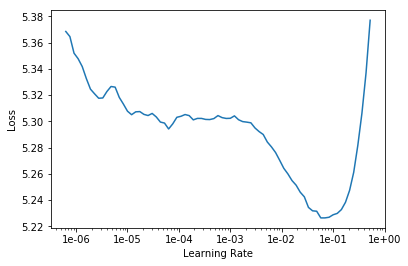

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

Total time: 11:35
epoch  train_loss  valid_loss  accuracy
1      4.588473    4.445626    0.250168  (11:35)



In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

Total time: 2:09:09
epoch  train_loss  valid_loss  accuracy
1      4.342993    4.278463    0.268850  (12:55)
2      4.250245    4.192998    0.279378  (12:57)
3      4.165312    4.144503    0.285050  (12:51)
4      4.121187    4.104517    0.289845  (12:54)
5      4.068878    4.078923    0.292670  (12:53)
6      4.028282    4.057202    0.295577  (12:57)
7      3.968565    4.043187    0.297289  (12:53)
8      3.893892    4.033587    0.298510  (12:54)
9      3.854538    4.030769    0.299093  (12:55)
10     3.808333    4.031565    0.299062  (12:56)



In [ ]:
learn.save('fine_tuned')

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
data_clas = (TextFileList.from_folder(path)
             #grap all the text files in path
            .label_from_folder(classes=['neg','pos'])
             #label them all with their folder, only keep 'neg' and 'pos'
            .split_by_folder(valid='test')
             #split by folder between train and validation set
            .datasets()
             #use `TextDataset`, the flag `is_fnames=True` indicates to read the content of the files passed
            .tokenize()
             #tokenize with defaults from fastai
            .numericalize(vocab = data_lm.vocab)
             #numericalize with the same vocabulary as our pretrained model
            .databunch(TextClasDataBunch, bs=50))
data_clas.save('tmp_clas')

In [ ]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=50)
data_clas.show_batch()

text,label
"xxfld 1 match 1 : tag team table match bubba ray and spike dudley vs eddie guerrero and chris benoit bubba ray and spike dudley started things off with a tag team table match against eddie guerrero and chris benoit . according to the rules of the match , both opponents have to go through tables in order to get the win . benoit and guerrero heated up early on by taking turns hammering first spike and then bubba ray . a german suplex by benoit to bubba took the wind out of the dudley brother . spike tried to",pos
"xxfld 1 i wo n't try to speculate as to what brando was attempting . at his best he turns in such oddball performances , insinuating so many things at once , that it does n't seem he does anything so much as play by unfailing instinct . often it seems he is calling attention to some favored aspect of his character over all others , a concentration which , if followed , turns out something of a red herring , as he turns out subtler , craftier than at first appeared . this is a mastery of artifice ,",pos
"xxfld 1 this was the second of two filmed "" hamlets "" in the nineties , the first being franco zeffirelli 's , starring mel gibson , from 1990 . zeffirelli 's version , like laurence olivier 's from 1948 , was based upon an abridged version of the play , with much of shakespeare 's original text being cut . ( i have never seen tony richardson 's 1969 version , but as that ran to less than two hours , shorter even than zeffirelli 's , i presume that was also abridged ) . kenneth branagh was attempting",pos
"xxfld 1 it 's always difficult to put a stamp on any film as being ' the best , ' whether of all time , a certain genre , or what have you , but i believe a strong argument could be made that in fact , laputa is the greatest animated film ever made . it is in my mind the masterwork of hayao miyazaki , the most talented of japan 's animated directors , and it best captures his strengths as a director , storyteller , and designer , as well as encapsulating all of his favorite underlying",pos
"xxfld 1 when i first popped in happy birthday to me , i checked the timer to see how long the film was . i was amazed at the length . both animated and horror films share a common ground : attention span of the selected audience and that should be at or right around 90 minutes . anything more , and you 'll lose the bulk of your audience . \n\n this 110 minutes , or 20 minutes past its prime was a huge problem for me . i 'd like to say half of this movie could 've",neg
"xxfld 1 linking story : another first - time viewing for me and , again , this is one of the most popular of the amicus anthologies - and it 's easy to see why , though i realize how the film 's rather meaningless title could be misleading for some ; i certainly fancied director peter duffell 's choice - xxup death xxup and xxup the xxup maiden ( which , incidentally , is a classical piece by schubert that is heard in the film during the peter cushing episode ) - a great deal more . though the",pos
"xxfld 1 this comment does contain spoilers ! ! \n\n there are few actors that have an intangible to them . that innate quality which is an amalgamation of charisma , panache and swagger . it 's the quality that can separate good actors from the truly great . i think george clooney has it and so does jack nicholson . you can look at clooney 's subtle touches in scenes like his one word good - bye to andy garcia in ocean 's 11 when they just utter each other 's name xxunk . "" terry . "" """,pos
"xxfld 1 was this a comedy or was it a drama ? i begin this review by asking this question because the film that i just witnessed , hollywood shuffle , was neither funny or rather dramatic . while it tried so hard to make a point , because of this lack of definition ( comedy or drama ) , the clever themes and pointed remarks were lost . while i am a strong believer that there is too much racial profiling happening in hollywood , even today , i do not believe that towns

We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 02:40
epoch  train_loss  valid_loss  accuracy
1      0.281750    0.209883    0.917120  (02:40)



In [ ]:
learn.save('first')

In [ ]:
learn.load('first')

TextClassifierLearner(data=<fastai.text.data.TextClasDataBunch object at 0x7efb33525dd8>, model=SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 02:57
epoch  train_loss  valid_loss  accuracy
1      0.234253    0.186893    0.929160  (02:57)



In [ ]:
learn.save('second')

In [ ]:
learn.load('second')

TextClassifierLearner(data=<fastai.text.data.TextClasDataBunch object at 0x7efb33525dd8>, model=SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 04:02
epoch  train_loss  valid_loss  accuracy
1      0.218634    0.157757    0.941840  (04:02)



In [ ]:
learn.save('third')

In [ ]:
learn.load('third')

TextClassifierLearner(data=<fastai.text.data.TextClasDataBunch object at 0x7efb33525dd8>, model=SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

Total time: 09:52
epoch  train_loss  valid_loss  accuracy
1      0.180064    0.151520    0.944040  (04:55)
2      0.142421    0.155700    0.944120  (04:56)

